In [ ]:
import os
import pickle
from functools import partial

import numpy as np
import pyabc
from fitmulticell import model as morpheus_model
from fitmulticell.sumstat import SummaryStatistics
from matplotlib import pyplot as plt
from tarp import get_tarp_coverage
from tqdm import tqdm

from load_bayesflow_model import load_model, custom_loader
from plotting_routines import plot_posterior_2d
from summary_stats import reduced_coordinates_to_sumstat, reduce_to_coordinates, \
    compute_mean_summary_stats

# get the job array id and number of processors
job_array_id = int(os.environ.get('SLURM_ARRAY_TASK_ID', 0))
n_procs = int(os.environ.get('SLURM_CPUS_PER_TASK', 1))
print(job_array_id)
on_cluster = False

In [ ]:
if on_cluster:
    gp = '/home/jarruda_hpc/CellMigration/synth_data_params_bayesflow'
else:
    gp = os.getcwd()

# defining the mapping of parameter inside the model xml file. the dictionary name is for 
# parameter name, and the value are the mapping values, to get the map value for parameter 
# check here: https://fitmulticell.readthedocs.io/en/latest/example/minimal.html#Inference-problem-definition

par_map = {
    'gradient_strength': './CellTypes/CellType/Constant[@symbol="gradient_strength"]',
    'move.strength': './CellTypes/CellType/Constant[@symbol="move.strength"]',
    'move.duration.mean': './CellTypes/CellType/Constant[@symbol="move.duration.mean"]',
    'cell_nodes_real': './Global/Constant[@symbol="cell_nodes_real"]',
}

model_path = gp + "/cell_movement_v24.xml"  # time step is 30sec, move.dir completely normalized, init move.dir rand in all directions
# defining the summary statistics function
max_sequence_length = 120
min_sequence_length = 0
only_longest_traj_per_cell = True  # mainly to keep the data batchable
sumstat = SummaryStatistics(sum_stat_calculator=partial(reduce_to_coordinates,
                                                        minimal_length=min_sequence_length,
                                                        maximal_length=max_sequence_length,
                                                        only_longest_traj_per_cell=only_longest_traj_per_cell))                    

if on_cluster:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        executable="ulimit -s unlimited; /home/jarruda_hpc/CellMigration/morpheus-2.3.7",
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

    # todo: remember also change tiff path in model.xml!
else:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)


# parameter values used to generate the synthetic data
obs_pars = {
    'gradient_strength': 100.,  # strength of the gradient of chemotaxis (energy potential)
    'move.strength': 10.,  # strength of directed motion (energy potential)
    'move.duration.mean': 0.1,  # mean of exponential distribution (seconds)
    'cell_nodes_real': 50.,  # volume of the cell  (\mu m^2)
}

obs_pars_log = {key: np.log10(val) for key, val in obs_pars.items()}
limits = {'gradient_strength': (1, 10000), #(10 ** 4, 10 ** 8),
          'move.strength': (1, 100),
          'move.duration.mean': (1e-4, 30), #(math.log10((10 ** -2) * 30), math.log10((10 ** 4))), # smallest time step in simulation 5
          'cell_nodes_real': (1, 300)}
limits_log = {key: (np.log10(val[0]), np.log10(val[1])) for key, val in limits.items()}


prior = pyabc.Distribution(**{key: pyabc.RV("uniform", loc=lb, scale=ub-lb)
                              for key, (lb, ub) in limits_log.items()})
param_names = list(obs_pars.keys())
log_param_names = [f'log_{p}' for p in param_names]
print(obs_pars)

In [ ]:
import tensorflow as tf
import bayesflow as bf
from bayesflow.simulation import GenerativeModel, Prior, Simulator


def prior_fun(batch_size: int) -> np.ndarray:
    samples = []
    for _ in range(batch_size):
        samples.append(list(prior.rvs().values()))
    return np.array(samples)


def generate_population_data(param_batch: np.ndarray, cells_in_population: int, max_length: int) -> np.ndarray:
    """
    Generate population data
    :param param_batch:  batch of parameters
    :param cells_in_population:  number of cells in a population (50)
    :param max_length:  maximum length of the sequence
    :return:
    """
    data_batch = []
    for params in param_batch:
        params_dict = {key: p for key, p in zip(obs_pars.keys(), params)}
        sim = model.sample(params_dict)
        data_batch.append(sim)  # generates a cell population in one experiment

    data_batch_transformed = np.ones((param_batch.shape[0], cells_in_population, max_length, 2)) * np.nan
    # each cell is of different length, each with x and y coordinates, make a tensor out of it
    n_cells_not_visible = 0
    for p_id, population_sim in enumerate(data_batch):
        if len(population_sim) == 0:
            # no cells were visible in the simulation
            n_cells_not_visible += 1
            continue
        for c_id, cell_sim in enumerate(population_sim):
            # pre-pad the data with zeros, but first write zeros as nans to compute the mean and std
            data_batch_transformed[p_id, c_id, -len(cell_sim['x']):, 0] = cell_sim['x']
            data_batch_transformed[p_id, c_id, -len(cell_sim['y']):, 1] = cell_sim['y']

    if n_cells_not_visible > 0:
        print(f'Simulation with no cells visible: {n_cells_not_visible}/{len(data_batch)}')
    return data_batch_transformed

In [ ]:
presimulate = False
presimulation_path = 'presimulations'
n_val_data = 100
cells_in_population = 50
n_params = len(obs_pars)
batch_size = 32
iterations_per_epoch = 100
# 1000 batches to be generated, 10 epochs until the batch is used again
epochs = 500

# check if gpu is available
print('gpu:', tf.config.list_physical_devices('GPU'))

bayesflow_prior = Prior(batch_prior_fun=prior_fun, param_names=param_names)
bayes_simulator = Simulator(batch_simulator_fun=partial(generate_population_data,
                                                        cells_in_population=cells_in_population,
                                                        max_length=max_sequence_length))
generative_model = GenerativeModel(prior=bayesflow_prior, simulator=bayes_simulator,
                                   skip_test=True,  # once is enough, simulation takes time
                                   name="Normalizing Flow Generative Model")

In [ ]:
if presimulate:
    print('presimulating')
    from time import sleep
    sleep(job_array_id)

    # we create on batch per job and save it in a folder
    epoch_id = job_array_id // iterations_per_epoch
    generative_model.presimulate_and_save(
        batch_size=batch_size,
        folder_path=presimulation_path+f'/epoch_{epoch_id}',
        iterations_per_epoch=1,
        epochs=1,
        extend_from=job_array_id,
        disable_user_input=True
    )
    print('Done!')

In [ ]:
if os.path.exists(os.path.join(gp, 'validation_data.pickle')):
    with open(os.path.join(gp, 'validation_data.pickle'), 'rb') as f:
        valid_data = pickle.load(f)
else:
    print('Generating validation data')
    valid_data = generative_model(n_val_data)
    # save the data
    with open(os.path.join(gp, 'validation_data.pickle'), 'wb') as f:
        pickle.dump(valid_data, f)

x_mean = np.nanmean(valid_data['sim_data'], axis=(0, 1, 2))
x_std = np.nanstd(valid_data['sim_data'], axis=(0, 1, 2))
p_mean = np.mean(valid_data['prior_draws'], axis=0)
p_std = np.std(valid_data['prior_draws'], axis=0)
print('Mean and std of data:', x_mean, x_std)
print('Mean and std of parameters:', p_mean, p_std)


# compute the mean of the summary statistics
summary_stats_list_ = [reduced_coordinates_to_sumstat(t) for t in valid_data['sim_data']]
(_, ad_averg, _, MSD_averg, _, TA_averg, _, VEL_averg, _, WT_averg) = compute_mean_summary_stats(summary_stats_list_, remove_nan=False)
direct_conditions_ = np.stack([ad_averg, MSD_averg, TA_averg, VEL_averg, WT_averg]).T
# replace inf with -1
direct_conditions_[np.isinf(direct_conditions_)] = np.nan
        
summary_valid_max = np.nanmax(direct_conditions_, axis=0)
summary_valid_min = np.nanmin(direct_conditions_, axis=0)

In [ ]:
job_array_id = 8  # best 5, ensemble 8, only summary network 10
trainer, map_idx_sim = load_model(
    model_id=job_array_id, 
    x_mean=x_mean,
    x_std=x_std,
    p_mean=p_mean,
    p_std=p_std,
    summary_valid_max=summary_valid_max,
    summary_valid_min=summary_valid_min,
    generative_model=generative_model
)

In [ ]:
# check if the model is already trained
if not os.path.exists(trainer.checkpoint_path):
    trainer._setup_optimizer(
        optimizer=None,
        epochs=epochs,
        iterations_per_epoch=iterations_per_epoch
    )

    history = trainer.train_from_presimulation(
        presimulation_path=presimulation_path,
        optimizer=trainer.optimizer,
        max_epochs=epochs,
        early_stopping=True,
        early_stopping_args={'patience': 17 - 2},
        custom_loader=custom_loader,
        validation_sims=valid_data
    )
    print('Training done!')
else:
    history = trainer.loss_history.get_plottable()

In [ ]:
bf.diagnostics.plot_losses(history['train_losses'], history['val_losses'], fig_size=(10, 6))
print('Final validation loss:', np.min(history['val_losses']))

# Diagnostic plots

In [ ]:
valid_data_config = trainer.configurator(valid_data)

In [ ]:
posterior_samples = trainer.amortizer.sample(valid_data_config, n_samples=1000)
posterior_samples = posterior_samples * p_std + p_mean
if isinstance(valid_data_config, list):  # for ensemble
    prior_draws = valid_data_config[0]["parameters"] * p_std + p_mean
else:
    prior_draws = valid_data_config["parameters"] * p_std + p_mean

In [ ]:
bf.diagnostics.plot_sbc_ecdf(posterior_samples, prior_draws, difference=True, param_names=log_param_names);
#plt.savefig(f'{trainer.checkpoint_path}/sbc_ecdf.png')

In [ ]:
bf.diagnostics.plot_recovery(posterior_samples, prior_draws, param_names=log_param_names);

In [ ]:
bf.diagnostics.plot_z_score_contraction(posterior_samples, prior_draws, param_names=log_param_names);

In [ ]:
posterior_samples_reshaped = posterior_samples.reshape(posterior_samples.shape[1],
                                                       posterior_samples.shape[0], posterior_samples.shape[2])

#references = trainer.amortizer.summary_net([vd['summary_conditions'] for vd in valid_data_config])
#references = np.median(references, axis=1) + np.random.uniform(-1, 1, references.shape[0])
#references = np.array([references] * n_params).T

In [ ]:
ecp_bootstrap, alpha = get_tarp_coverage(posterior_samples_reshaped, prior_draws,
                                         references='random', norm=True, bootstrap=True)

In [ ]:
k_sigma = [1, 2, 3]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot([0, 1], [0, 1], ls='--', color='k', label="Ideal case")
ax.plot(alpha, ecp_bootstrap.mean(axis=0), label='TARP')
for k in k_sigma:
    ax.fill_between(alpha, 
                    ecp_bootstrap.mean(axis=0) - k * ecp_bootstrap.std(axis=0), 
                    ecp_bootstrap.mean(axis=0) + k * ecp_bootstrap.std(axis=0), 
                    alpha = 0.7)
ax.legend()
ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")
plt.show()

# Test on synthetic data

In [ ]:
# simulate test data
test_params = np.array(list(obs_pars_log.values()))
if not os.path.exists(os.path.join(gp, 'test_sim.npy')):
    test_sim_full = bayes_simulator(test_params[np.newaxis])
    test_sim = test_sim_full['sim_data']
    np.save(os.path.join(gp, 'test_sim.npy'), test_sim)
else:
    test_sim = np.load(os.path.join(gp, 'test_sim.npy'))
    test_sim_full = {'sim_data': test_sim}
test_sim.shape

In [ ]:
test_posterior_samples = trainer.amortizer.sample(trainer.configurator(test_sim_full), n_samples=1000)
test_posterior_samples = test_posterior_samples * p_std + p_mean
test_posterior_samples_median = np.median(test_posterior_samples, axis=0)
# compute the log posterior of the test data
input_dict = {
    'sim_data': np.repeat(test_sim, repeats=100, axis=0),
    'parameters': test_posterior_samples
}

# save posterior samples to load in abc results
#np.save(f'{trainer.checkpoint_path}/posterior_samples_synthetic.npy', test_posterior_samples)

In [ ]:
fig = plot_posterior_2d(posterior_draws=test_posterior_samples,
                        prior_draws=prior_draws[:test_posterior_samples.shape[0]],
                        param_names=log_param_names,
                        true_params=test_params,
                        height=2.5)
plt.show()

In [ ]:
if trainer.amortizer.summary_loss is not None:
    test_data_config = trainer.configurator(test_sim_full)
    
    MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
        observed_data=test_data_config, 
        reference_data=valid_data_config,  # if not provided, will use the generative model
        num_null_samples=500,
        bootstrap=True  # if True, use the reference data as null samples
    )
    fig = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)
    fig.savefig(f'{trainer.checkpoint_path}/Synthetic MMD.png', bbox_inches='tight')
    plt.show()

# Real Data

In [ ]:
from load_data import load_real_data

wasserstein_distance_dict = {0: np.nan, 1: np.nan}
samples_dict = {0: np.nan, 1: np.nan}
prior_draws = prior_fun(1000)

In [ ]:
real_data_id = [0, 1][1]
_, real_data_full = load_real_data(data_id=real_data_id,
                                   max_sequence_length=max_sequence_length,
                                   cells_in_population=cells_in_population,
                                   plot_data=True)
print(real_data_full.shape)

In [ ]:
# make sure that the sub-selected data size is well mixed based on track lengths
import pandas as pd

track_length = []
for cell in real_data_full:
    new_track_length = max_sequence_length-np.isnan(cell[:, 0]).sum()
    track_length.append(new_track_length)
track_length = np.array(track_length)

# Convert to DataFrame for handling
data = pd.DataFrame({'track_length': track_length, 'id': np.arange(len(track_length))})

# Define number of bins
num_bins = 10  # Adjust for resolution
data['bin'] = pd.cut(data['track_length'], bins=num_bins)

# Sample an equal number of points from each bin
sampled_data = data.groupby('bin').apply(lambda x: x.sample(min(len(x), 5))).reset_index(drop=True)
real_data_50 = real_data_full[sampled_data['id']]

Zelldichte macht was aus

Wo wollen Zellen hin? welche parameter beeinflussen das ganze? Zelldichte?

1,5mm

1 (nicht so gut, extrema)
739.79x279.74  microns
20231x768 pixel


2 (wesentlich mehr der Wahrheit)
882.94x287.03 microns
2424x788 pixel


In [ ]:
# batch the real data
n_cell_in_batch = [len(real_data_full), cells_in_population][0]  # 0: joint, 1: combined posterior
batches = [real_data_full[i * n_cell_in_batch:(i + 1) * n_cell_in_batch]
           for i in range(len(real_data_full) // n_cell_in_batch)]
#batches = [real_data_50]  # single posterior
real_posterior_samples_full = []
n_samples = prior_draws.shape[0] // len(batches)

for b in tqdm(batches):
    print(b.shape)
    real_posterior_samples = trainer.amortizer.sample(trainer.configurator({'sim_data': b[np.newaxis]}), 
                                          n_samples=n_samples)
    real_posterior_samples = real_posterior_samples * p_std + p_mean
    real_posterior_samples_full.append(real_posterior_samples)
    
    #np.save(f'{trainer.checkpoint_path}/posterior_samples_real_50.npy', real_posterior_samples)
    #np.save(f'{trainer.checkpoint_path}/posterior_samples_real.npy', real_posterior_samples)
    
real_posterior_samples = np.concatenate(real_posterior_samples_full)
samples_dict[real_data_id] = real_posterior_samples

In [ ]:
fig = plot_posterior_2d(posterior_draws=real_posterior_samples,
                        prior_draws=prior_draws[:real_posterior_samples.shape[0]],
                        param_names=log_param_names,
                        height=2.5)
#plt.savefig(f'{trainer.checkpoint_path}/single_posterior.png')
plt.show()

In [ ]:
if trainer.amortizer.summary_loss is not None:
    from matplotlib.cm import viridis
    real_data_config = trainer.configurator({'sim_data': batches})
    summary_statistics = trainer.amortizer.summary_net(valid_data_config['summary_conditions'])
    summary_statistics_obs = trainer.amortizer.summary_net(real_data_config['summary_conditions'])
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    colors = viridis(np.linspace(0.1, 0.9, 2))
    ax.scatter(
        summary_statistics_obs[:, 0], summary_statistics_obs[:, 1], color=colors[0], label=r"Observed: $h_{\psi}(x_{obs})$"
    )
    ax.scatter(summary_statistics[:, 0], summary_statistics[:, 1], color=colors[1], label=r"Well-specified: $h_{\psi}(x)$")
    ax.legend()
    ax.grid(alpha=0.2)
    plt.gca().set_aspect("equal")
    
    #fig.savefig(f'{trainer.checkpoint_path}/Real_{real_data_id} Summary Latent Space.png',
    #            bbox_inches='tight')
    
    MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
        observed_data=real_data_config, 
        reference_data=valid_data_config,  # if not provided, will use the generative model
        num_null_samples=500,
        bootstrap=True  # if True, use the reference data as null samples
    )
    fig = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)
    fig.savefig(f'{trainer.checkpoint_path}/Real_{real_data_id} MMD.png',
                bbox_inches='tight')
    plt.show()

# Different Number of Cells in Experiment

In [ ]:
# batch the real data
n_cell_in_batch = 1
batches = [real_data_full[i * n_cell_in_batch:(i + 1) * n_cell_in_batch]
           for i in range(len(real_data_full) // n_cell_in_batch)]
real_posterior_samples_full = []

for b in tqdm(batches):
    real_posterior_samples = trainer.amortizer.sample(trainer.configurator({'sim_data': b[np.newaxis]}),
                                          n_samples=100)
    real_posterior_samples = real_posterior_samples * p_std + p_mean
    real_posterior_samples_full.append(real_posterior_samples)

In [361]:
# compute summary stats and correlation with individual parameters
# might not be a really reliable estimate of the parameter though
from summary_stats import velocity, angle_degree, MSD, turning_angle
from scipy.stats import linregress
from scipy.stats import median_abs_deviation

track_length = []

turning_angles = []
angle_degrees = []
msds = []
velo = []

chemokine_strength = []
persistence_strength = []
waiting_time = []
cell_volume = []
for ps, cell in zip(real_posterior_samples_full, real_data_full):
    new_track_length = max_sequence_length-np.isnan(cell[:, 0]).sum()
    if new_track_length > 2:
        #if np.nanmean(velocity(dict(x=cell[:, 0], y=cell[:, 1]))) > 3.8:
        #    continue
        track_length.append(new_track_length)

        turning_angles.append(np.nanmean(turning_angle(dict(x=cell[:, 0], y=cell[:, 1]))))
        angle_degrees.append(np.nanmean(angle_degree(dict(x=cell[:, 0], y=cell[:, 1]))))
        msds.append(np.nanmean(MSD(dict(x=cell[:, 0], y=cell[:, 1]), all_time_lags=False)))
        velo.append(np.nanmean(velocity(dict(x=cell[:, 0], y=cell[:, 1]))))

        chemokine_strength.append(np.mean(ps[:, 0]))
        persistence_strength.append(np.mean(ps[:, 1]))
        waiting_time.append(np.mean(ps[:, 2]))
        cell_volume.append(np.mean(ps[:, 3]))

track_length = np.array(track_length)
turning_angles, angle_degrees, msds, velo = np.array(turning_angles), np.array(angle_degrees), np.array(msds), np.array(velo)
chemokine_strength, persistence_strength, waiting_time, cell_volume = np.array(chemokine_strength), np.array(persistence_strength), np.array(waiting_time), np.array(cell_volume)

list_params = [chemokine_strength, persistence_strength, waiting_time, cell_volume] #, track_length]
list_stats = [turning_angles, angle_degrees, msds, velo, track_length]

reg_output = {
    'Turning Angle': [linregress(turning_angles, p) for p in list_params],
    'Angle Degree': [linregress(angle_degrees, p) for p in list_params],
    'MSD($\\tau=1$)': [linregress(msds, p) for p in list_params],
    'Velocity': [linregress(velo, p) for p in list_params],
    #'Track Length': [linregress(track_length, p) for p in list_params],
}

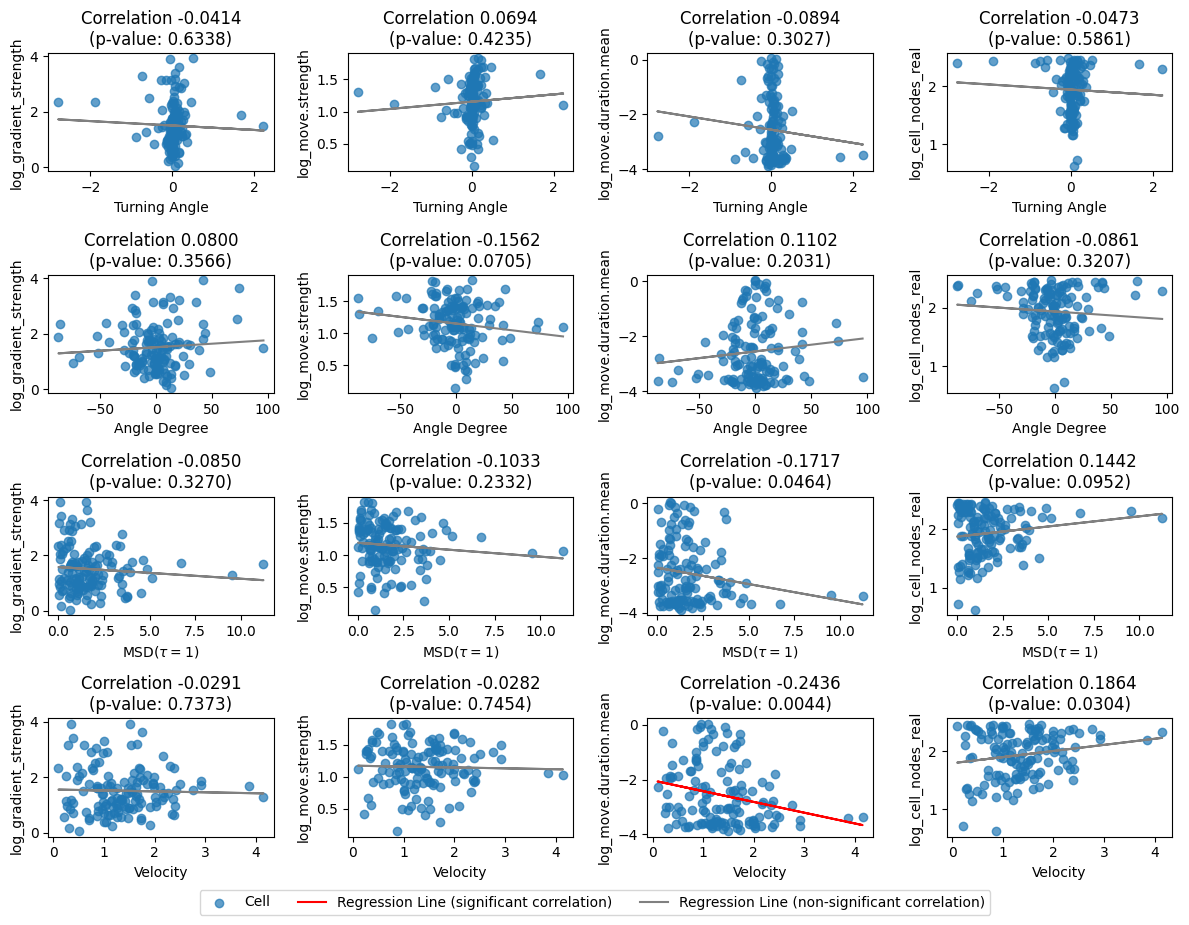

In [368]:
# Plot the correlation
fig, ax = plt.subplots(len(reg_output.keys()), 4, sharex='row', sharey='col', figsize=(12, 9), tight_layout=True)

for j, (key, list_p) in enumerate(reg_output.items()):
    for i in range(len(list_p)):
        #if i == len(list_p)-1 and j == len(reg_output.keys())-1:
        #    continue
        reg = list_p[i]

        ax[j, i].scatter(list_stats[j], list_params[i], alpha=0.7, label='Cell' if i == 0 and j == 0 else None)
        if reg.pvalue < 0.01:
            ax[j, i].plot(list_stats[j], reg.slope*list_stats[j] + reg.intercept,
                     color='red', label=f'Regression Line (significant correlation)' if i == 2 and j == 3 else None)
        else:
            ax[j, i].plot(list_stats[j], reg.slope*list_stats[j] + reg.intercept,
                     color='gray', label=f'Regression Line (non-significant correlation)' if i == 3 and j == 3 else None)

        ax[j, i].set_title(f"Correlation {reg.rvalue:.4f}\n(p-value: {reg.pvalue:.4f})")
        ax[j, i].set_xlabel(key)
        ax[j, i].set_ylabel((log_param_names + ['Track Length'])[i])
        #if i != len(list_p)-1:
        #    ax[j, i].set_ylim(limits_log[param_names[i]])

#ax[-1, -1].axis('off')
fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.03))
#plt.savefig(f'{trainer.checkpoint_path}/real_parameter_vs_stats.png', bbox_inches='tight')
plt.show()

In [433]:
# batch the real data
n_cell_in_batch = np.arange(1, len(real_data_full))
stats_n_cells = {}
np.random.seed(0)

real_posterior_samples_partial = []
real_posterior_samples_artificial = []
for n_cells in tqdm(n_cell_in_batch):
    n_rand_index = np.random.choice(len(real_data_full), size=n_cells, replace=False)
    partial_data = real_data_full[n_rand_index]

    real_posterior_samples = trainer.amortizer.sample(trainer.configurator({'sim_data': partial_data[np.newaxis]}),
                                                      n_samples=100)
    real_posterior_samples = real_posterior_samples * p_std + p_mean
    real_posterior_samples_partial.append(real_posterior_samples)

    # fill with nan to get full data set
    full_artificial_data = np.ones_like(real_data_full) * np.nan
    full_artificial_data[:partial_data.shape[0]] = partial_data

    real_posterior_samples = trainer.amortizer.sample(trainer.configurator({'sim_data': full_artificial_data[np.newaxis]}),
                                                      n_samples=100)
    real_posterior_samples = real_posterior_samples * p_std + p_mean
    real_posterior_samples_artificial.append(real_posterior_samples)

real_posterior_samples_partial = np.stack(real_posterior_samples_partial)
real_posterior_samples_artificial = np.stack(real_posterior_samples_artificial)

  4%|▎         | 5/142 [00:12<05:38,  2.47s/it]/Users/jonas.arruda/PyCharm Projects/CellMigration/learned_summaries/summary_stats.py:209: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/Users/jonas.arruda/PyCharm Projects/CellMigration/learned_summaries/summary_stats.py:225: RuntimeWarning: Degrees of freedom <= 0 for slice.
  return np.nanvar(x)
100%|██████████| 142/142 [11:08<00:00,  4.70s/it]


In [434]:
real_posterior_samples_partial_median = np.median(real_posterior_samples_partial, axis=1)
real_posterior_samples_partial_std = median_abs_deviation(real_posterior_samples_partial, axis=1)

real_posterior_samples_artificial_median = np.median(real_posterior_samples_artificial, axis=1)
real_posterior_samples_artificial_std = median_abs_deviation(real_posterior_samples_artificial, axis=1)

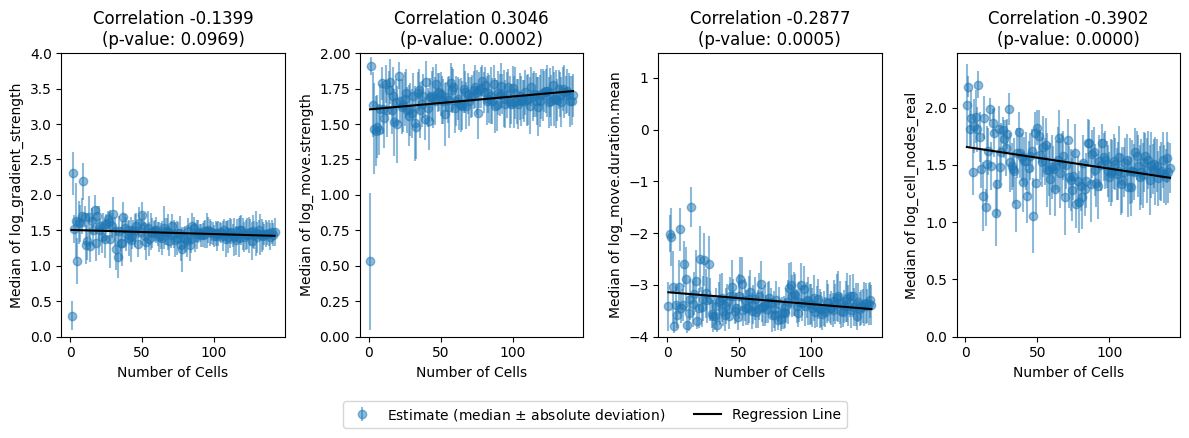

In [446]:
fig, ax = plt.subplots(1, 4, sharex='row', sharey='col', figsize=(12, 4), tight_layout=True)

for i, p_name in enumerate(log_param_names):
    reg = linregress(n_cell_in_batch, real_posterior_samples_partial_median[:, i])

    ax[i].errorbar(n_cell_in_batch,  real_posterior_samples_partial_median[:, i],
                  yerr=real_posterior_samples_partial_std[:, i],
                  fmt='o',
                  alpha=0.5, label='Estimate (median $\pm$ absolute deviation)' if i == 0 else None)

    reg = linregress(n_cell_in_batch, real_posterior_samples_partial_median[:, i])
    #if reg.pvalue < 0.01:
    ax[i].plot(n_cell_in_batch, reg.slope*n_cell_in_batch + reg.intercept,
                     color='black', label=f'Regression Line' if i == 1 else None,
                   zorder=4)


    ax[i].set_title(f"Correlation {reg.rvalue:.4f}\n(p-value: {reg.pvalue:.4f})")
    ax[i].set_xlabel('Number of Cells')
    ax[i].set_ylabel(f'Median of {log_param_names[i]}')
    ax[i].set_ylim(limits_log[param_names[i]])

fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))
plt.savefig(f'{trainer.checkpoint_path}/real_ncells_vs_parameter_median.png', bbox_inches='tight')
plt.show()

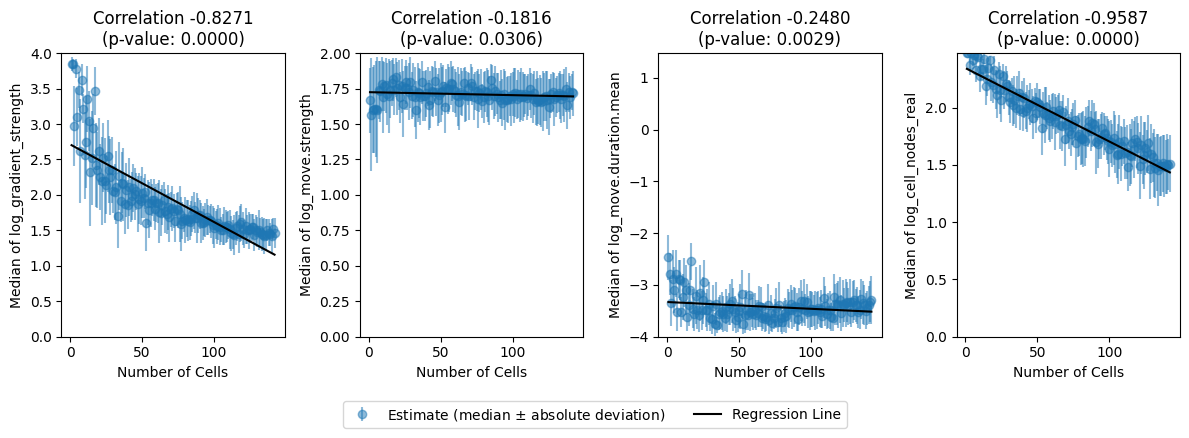

In [447]:
fig, ax = plt.subplots(1, 4, sharex='row', sharey='col', figsize=(12, 4), tight_layout=True)

for i, p_name in enumerate(log_param_names):
    reg = linregress(n_cell_in_batch, real_posterior_samples_artificial_median[:, i])

    ax[i].errorbar(n_cell_in_batch,  real_posterior_samples_artificial_median[:, i],
                  yerr=real_posterior_samples_artificial_std[:, i],
                  fmt='o',
                  alpha=0.5, label='Estimate (median $\pm$ absolute deviation)' if i == 0 else None)

    reg = linregress(n_cell_in_batch, real_posterior_samples_artificial_median[:, i])
    ax[i].plot(n_cell_in_batch, reg.slope*n_cell_in_batch + reg.intercept,
                     color='black', label=f'Regression Line' if i == 1 else None,
                   zorder=4)

    ax[i].set_title(f"Correlation {reg.rvalue:.4f}\n(p-value: {reg.pvalue:.4f})")
    ax[i].set_xlabel('Number of Cells')
    ax[i].set_ylabel(f'Median of {log_param_names[i]}')
    ax[i].set_ylim(limits_log[param_names[i]])

fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))
plt.savefig(f'{trainer.checkpoint_path}/real_ncells_padded_vs_parameter_median.png', bbox_inches='tight')
plt.show()